In [1]:
import shapely.geometry as sg
import shapely
import numpy as np
import random
import math

import pandas as pd

In [2]:
def update_poly_pickle(poly, return_df=False):
    try:
        df_poly = pd.read_pickle('./randpolys.pkl')
    except:
#         just make a new df
        print('making new poly df...')
        df_poly = make_poly_df()

#     get next loc
    df_idx_next = len(df_poly)
    df_poly.loc[df_idx_next] = poly.wkt
    df_poly = df_poly.drop_duplicates(ignore_index=True)

    df_poly.to_pickle('./randpolys.pkl')
    
    print('done')
    if return_df:
        return df_poly
    
def make_poly_df():
    poly_df = pd.DataFrame(columns=['poly_wkt'])
    poly_df.to_pickle('./randpolys.pkl')
    return poly_df

In [3]:
def get_angles(vec_1,vec_2):
    dot = np.dot(vec_1, vec_2)
    det = np.cross(vec_1,vec_2)
    angle_in_rad = np.arctan2(det,dot)
    return np.degrees(angle_in_rad)


def simplify_by_interior_angle(poly_in, deg_tol = 5):
    """
    try to remove persistent coordinate points that remain after
    simplify, convex hul, etc with some trig
    params:
    
    """
    
    ext_poly_coords = poly_in.exterior.coords[:]
#     ext_poly_coords = ext_poly_coords[1:] + ext_poly_coords[:1]
#     # reassign last to first, so we have a proper linear ring sequence for shapely polygon
#     ext_poly_coords[-1] = ext_poly_coords[0]
    vector_rep = np.diff(ext_poly_coords,axis = 0)
    angles_list = []
    for i in range(0,len(vector_rep) -1 ):
        angles_list.append(np.abs(get_angles(vector_rep[i],vector_rep[i+1])))
    
  
    thresh_vals_by_deg = np.where(np.array(angles_list) > deg_tol)
#   gotta be a better way to do this. sandwich betweens first and last pts
    new_idx = [0] + (thresh_vals_by_deg[0] + 1).tolist() + [0]
    new_vertices = [ext_poly_coords[idx] for idx in new_idx]
    
#     add geom type check l8r, for now only interested in poly
#     try:
#         return sg.Polygon(new_vertices)
#     except:
#         return vector_rep
    return sg.Polygon(new_vertices)

def poly_as_mpt(polygon):
    coords = polygon.exterior.coords[:]
    as_pts = [sg.Point(x) for x in coords]
    as_mpt = sg.MultiPoint(as_pts)
    return as_mpt
        

# # try random geoms

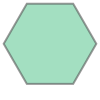

In [4]:
def make_hex_poly(a, x, y):
    """
    Create a hexagon centered on (x, y)
    :param a: length of the hexagon's edge
    :param x,y: desired centroid of hex
    :return: The shapely polygon representation of the hexagon
    """
    hex_coords = [(x + math.cos(math.radians(angle)) * a, y + math.sin(math.radians(angle)) * a) for angle in range(0, 360, 60)]
    return sg.Polygon(hex_coords)
hex1 = make_hex_poly(5,10,10)
hex1

In [5]:
def generate_degen(geom,pps=5):
    """
    geom is the input shapely type polygon (must be valid pls)
    pps is points per side to generate fr the polygon
    """
    
#     pps=5 # points per side
    
    
#     get normalized vec values
    coords = geom.exterior.coords[:]
    coords_arr = np.array(coords)
    vector_rep = np.diff(coords_arr,axis = 0)
    distances = np.linalg.norm(vector_rep,axis = 1)
    
    idx_dict = {"distance":0, 
               "vector":1,
               "coords":2}
    
    final_coords=[]
    dist_scaler = 10
    for e,d_v_c in enumerate(zip(distances,vector_rep,coords_arr)):
        d= d_v_c[idx_dict['distance']]
        v = d_v_c[idx_dict['vector']]
        c = d_v_c[idx_dict['coords']]
#         print(c)
        u = v/d
#         side_pts = np.random.randint(1,d*10,(pps))/11 # dont want a chance of zero 
        side_pts = random.sample(range(1, math.floor(d*dist_scaler)), pps)
    
        # maintain proper sequence by sorting distance scalars and prepending starting pt of current vector
        side_pts.sort() 
        new_offset = [c + u*du/dist_scaler for du in side_pts]
        final_coords+= [c] + new_offset #+ list(coords[e+1])
        
    return final_coords
#         print(u)
        

In [6]:
after = generate_degen(hex1)

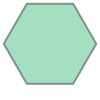

In [7]:
sg.Polygon(after)

In [8]:
after_pts = [sg.Point(x) for x in after]
after_mpts = sg.MultiPoint(after_pts)

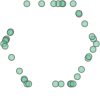

In [9]:
after_mpts


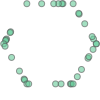

In [10]:
poly_as_mpt(sg.Polygon(after_pts))

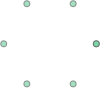

In [11]:
poly_as_mpt(simplify_by_interior_angle(sg.Polygon(after_pts)))

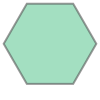

In [12]:
after_sim = simplify_by_interior_angle(sg.Polygon(after))
after_sim

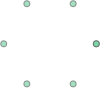

In [13]:
poly_as_mpt(after_sim)

In [14]:
len(after_sim.exterior.coords[:])

7

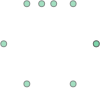

In [21]:
# with simplify og
test_simp = sg.Polygon(after).simplify(1e-15)
poly_as_mpt(test_simp)


In [ ]:
def generate_random_polygon( n):

    x = np.random.randint(0,50,n)
    y = np.random.randint(0,50,n)
    centroid = [np.sum(x)/n, np.sum(y)/n]

    angles = np.arctan2(x-centroid[0], y-centroid[1])

    ##sorting the points by angle
    coords_by_theta = sorted([((xx,yy),theta) for xx,yy,theta in zip(x,y,angles)], key = lambda t: t[1])

    ##making sure that there are no duplicates:
    if len(coords_by_theta) != len(set(coords_by_theta)):
        raise Exception('need re run (recurse potentially in future)')

    xy,angles = zip(*coords_by_theta)
#     append first point to end for complete linear ring sequence
#     xy.append(xy[0])
    xy = list(xy)
    xy.append(xy[0])
    return xy



In [ ]:
vals = generate_random_polygon(7)
# rand_poly = sg.Polygon(sg.Point(x) for x in vals)
rand_poly=sg.Polygon(vals)
rand_poly

In [ ]:
test_df = update_poly_pickle(rand_poly,return_df=True)
test_df.tail(10)

In [ ]:
simplify_by_interior_angle(rand_poly)

In [ ]:
poly_as_mpt(rand_poly)

In [ ]:
# pt bufferer


In [ ]:
len(poly_as_mpt(simplify_by_interior_angle(rand_poly)))

In [ ]:
buffpt = [sg.Point(x).buffer(1) for x in vals]
sg.MultiPolygon(buffpt).union(rand_poly.exterior)


In [ ]:
def buffer_poly_vtx(poly,buffer=1):
    pts = poly.exterior.coords[:]
    buffpts = [sg.Point(x).buffer(1) for x in pts]
    buffpts = sg.MultiPolygon(buffpts)
    poly_ext = poly.exterior
#     return geom collection
    try:
        return poly_ext.union(buffpts)    
    except Exception as e:
        print(e)

In [ ]:
buffer_poly_vtx(poly= rand_poly,buffer=1)

In [ ]:
rand_degen = generate_degen(rand_poly)
rd_poly = sg.Polygon(rand_degen)

In [ ]:
poly_as_mpt(rd_poly)

In [ ]:
buffer_poly_vtx(rd_poly,buffer=.0000000001)

In [ ]:
sv = 1e-1

# simpol =rd_poly.simplify(sv,preserve_topology=True)
simpol =rd_poly.simplify(sv,preserve_topology=False)
print(len(poly_as_mpt(simpol)))
print('target num vertx ', len(vals))
buffer_poly_vtx(simpol)

In [ ]:
intpol= simplify_by_interior_angle(rd_poly,deg_tol=1)
# intpol= simplify_by_interior_angle(rd_poly)
print(len(poly_as_mpt((intpol))))
print('target num vtx', len(vals))
buffer_poly_vtx(intpol)

In [ ]:
buffer_poly_vtx(rand_poly)

In [ ]:
poly_as_mpt(rand_poly)